### know the categories

In [17]:
import os
from PIL import Image as PILImage
from PIL import ImageEnhance, ImageFilter
from IPython.display import Image, display
import shutil
import numpy as np
import matplotlib.pyplot as plt
import random

def resize224_image(img: PILImage.Image) -> PILImage.Image:
    w, h = img.size
    min_side = min(w, h)

    # Center crop
    left   = (w - min_side) // 2
    top    = (h - min_side) // 2
    right  = left + min_side
    bottom = top + min_side

    img_cropped = img.crop((left, top, right, bottom))
    img_resized = img_cropped.resize((224, 224), PILImage.LANCZOS)

    return img_resized

def augment_image(img):
    method = random.choice(["brightness", "contrast", "noise", "blur", "resize", "rotate"])

    if method == "brightness":
        factor = random.uniform(0.6, 1.4)
        return ImageEnhance.Brightness(img).enhance(factor)

    elif method == "contrast":
        factor = random.uniform(0.6, 1.4)
        return ImageEnhance.Contrast(img).enhance(factor)

    elif method == "noise":
        img_np = np.array(img)
        noise = np.random.normal(0, 15, img_np.shape).astype(np.int16)
        img_np = np.clip(img_np + noise, 0, 255).astype(np.uint8)
        return PILImage.fromarray(img_np)

    elif method == "blur":
        radius = random.uniform(0.5, 2.0)
        return img.filter(ImageFilter.GaussianBlur(radius=radius))
    
    elif method == "resize":
        scale = random.uniform(0.8, 0.9)
        w, h = img.size
        new_w, new_h = int(w * scale), int(h * scale)
        small = img.resize((new_w, new_h), PILImage.LANCZOS)
        new_img = PILImage.new("RGB", (w, h), (255, 255, 255))
        offset = ((w - new_w) // 2, (h - new_h) // 2)
        new_img.paste(small, offset)
        return new_img

    elif method == "rotate":
        angle = random.uniform(-10, 10)
        return img.rotate(angle, resample=PILImage.BICUBIC, expand=False, fillcolor=(255, 255, 255))

    return img

### For big dataset

select the target categories from /images to /cn_ft

resize to 224*224 from /cn_ft to /cn_ft_224

In [18]:
# Mapping from prefix to category name
prefix_map = {
    "000": "speed limit",
    "001": "speed limit",
    "002": "speed limit",
    "003": "speed limit",
    "004": "speed limit",
    "005": "speed limit",
    "006": "speed limit",
    "007": "speed limit",
    # "010": "no proceed straight",
    # "011": "no left turn",
    # "013": "no right turn",
    "014": "no overtaking",
    "015": "no U-turn",
    # "016": "no motor vehicles",
    # "017": "no honking",
    # "018": "end of speed limit",
    # "019": "end of speed limit",
    "022": "left turn",
    "024": "right turn",
    "035": "pedestrian crossing",
    "036": "cycle crossing",
    "037": "school zone",
    "040": "steep descent",
    "041": "steep ascent",
    # "042": "slow",
    "047": "railway crossing",
    "048": "road work ahead",
    "050": "railway crossing",
    # "051": "accident ahead",
    "052": "stop",
    # "053": "no entry for all",
    "054": "no stopping",
    "055": "no entry for vehicles",
    "056": "give way",
}

src_folder = "images"
dst_folder = "cn"  # for all

os.makedirs(dst_folder, exist_ok=True)

# 分类采样
category_files = {}
for fname in os.listdir(src_folder):
    if not fname.lower().endswith(".png"):
        continue
    prefix = fname[:3]
    if prefix not in prefix_map:
        continue
    category = prefix_map[prefix]
    category_files.setdefault(category, []).append(fname)

# 采样 + resize + 保存
for category, files in category_files.items():
    sampled = random.sample(files, min(20, len(files)))
    safe_cat = category.lower().replace(" ", "_").replace("-", "_")
    for idx, fname in enumerate(sampled):
        new_name = f"{safe_cat}_{idx:03d}.png"
        src_path = os.path.join(src_folder, fname)
        img = PILImage.open(src_path).convert("RGB")
        resized_img = resize224_image(img)
        dst_path = os.path.join(dst_folder, new_name)
        resized_img.save(dst_path)

print("Done.")

Done.


### For standard signs

resize to 224*224 from /cn_one to /cn_one_224

In [19]:
src_folder = "cn_one"

os.makedirs(dst_folder, exist_ok=True)

for fname in os.listdir(src_folder):
    if not fname.lower().endswith(".png"):
        continue

    src_path = os.path.join(src_folder, fname)
    img = PILImage.open(src_path).convert("RGB")

    # 数据增强 + resize
    augmented = augment_image(img)
    resized = resize224_image(augmented)

    # 保存
    dst_path = os.path.join(dst_folder, fname)
    resized.save(dst_path)

print("Done.")

Done.


### For height/width/weight limit

generate from /cn_limit to /cn_unlimited and resize to /cn_unlimited_224

In [20]:
src_folder = "cn_limit"

os.makedirs(dst_folder, exist_ok=True)

for fname in os.listdir(src_folder):
    if not fname.lower().endswith(".png"):
        continue
    if not (fname.endswith("_0.png") or fname.endswith("_5.png")):
        continue

    src_path = os.path.join(src_folder, fname)
    img = PILImage.open(src_path).convert("RGB")

    base_name = "_".join(fname.split("_")[:-1])  # 去掉编号
    # 保存原图（未增强，仅 resize）
    resized = resize224_image(img)
    dst_path = os.path.join(dst_folder, fname)
    resized.save(dst_path)

    # 决定增强起始下标
    if fname.endswith("_0.png"):
        start_idx = 1
    else:
        start_idx = 6

    for i in range(start_idx, start_idx + 4):
        aug_img = augment_image(img)
        aug_resized = resize224_image(aug_img)
        aug_name = f"{base_name}_{i}.png"
        aug_path = os.path.join(dst_folder, aug_name)
        aug_resized.save(aug_path)

print("Done.")

Done.


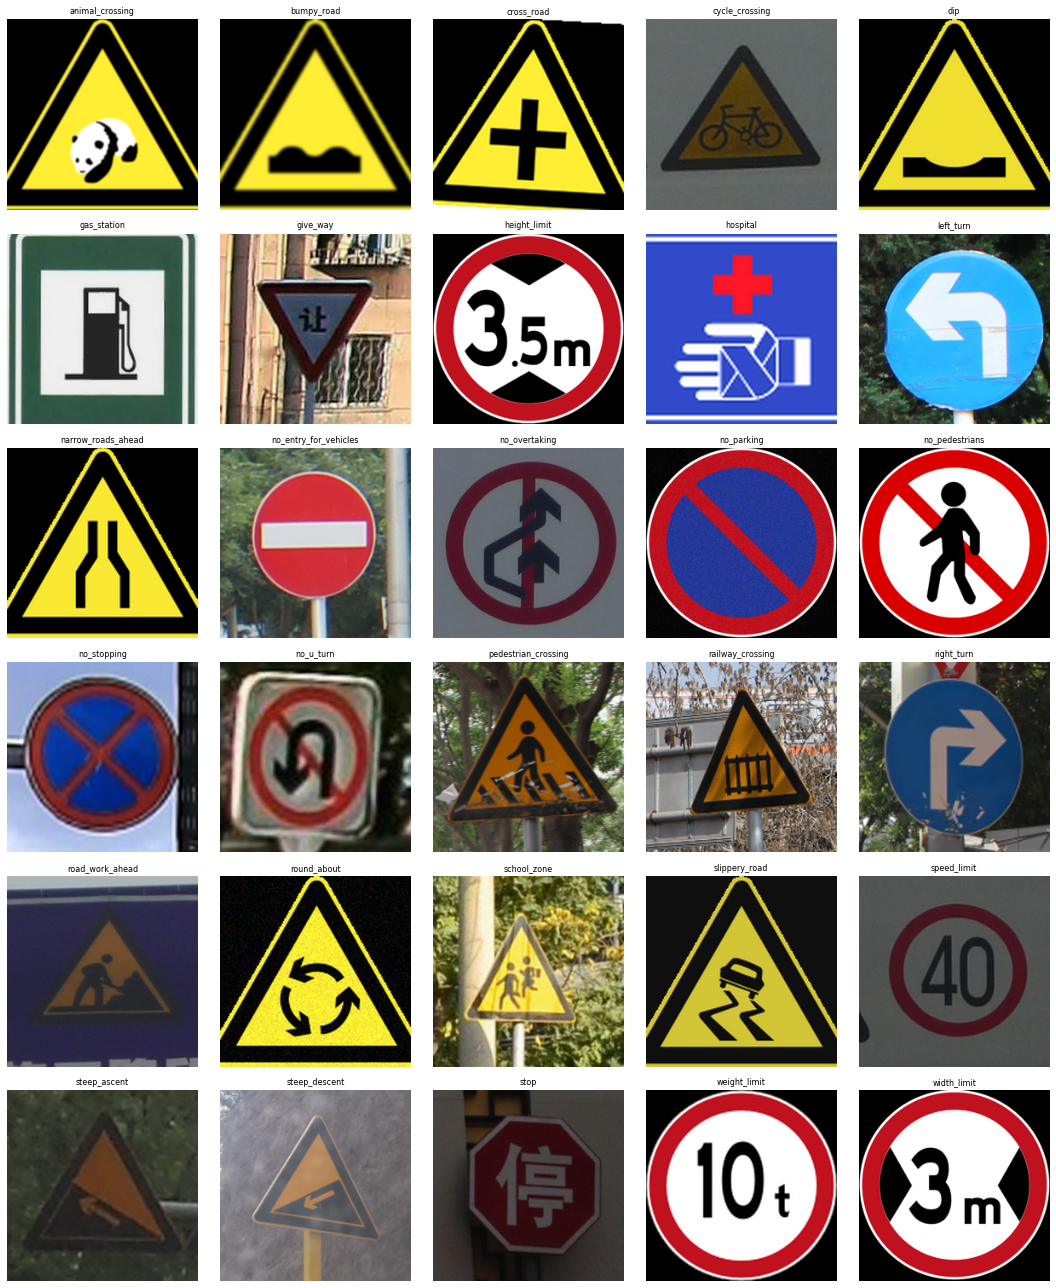

In [21]:
import os
from PIL import Image
import matplotlib.pyplot as plt

folder_path = "cn"

# 存储每个类别的第一张图像
first_images = {}

# 遍历文件夹中所有 .png 文件
for fname in sorted(os.listdir(folder_path)):
    if not fname.lower().endswith(".png"):
        continue
    # 提取类别名（文件名去掉最后一个 _编号部分）
    category = "_".join(fname.split("_")[:-1])
    if category not in first_images:
        first_images[category] = fname

# 加载图像和标题
images = []
titles = []

for category, fname in sorted(first_images.items()):
    img_path = os.path.join(folder_path, fname)
    img = Image.open(img_path)
    images.append(img)
    titles.append(category)

# 显示图像网格
num_images = len(images)
cols = 5
rows = (num_images + cols - 1) // cols

plt.figure(figsize=(15, rows * 3))

for i, (img, title) in enumerate(zip(images, titles)):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(title, fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()
